# Disaster Tweets Classification with NLP

In this notebook, we will use the **Disaster Tweets** dataset to classify tweets as disaster-related or not. We will use Natural Language Processing (NLP) techniques and explore different models, including **Naive Bayes**, **LSTM**, and **CatBoost** with text features.

In [1]:
# Install required libraries
!pip install catboost nltk tensorflow

In [2]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, SpatialDropout1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from catboost import CatBoostClassifier, Pool

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/verb.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/README  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.sense  
  inflating: /usr/share/nltk_data

## 1. Load the Dataset

We will use the [Disaster Tweets dataset](https://www.kaggle.com/c/nlp-getting-started/data), which contains tweets labeled as disaster (1) or non-disaster (0).

In [4]:
# Load the dataset
df = pd.read_csv("../input/nlp-getting-started/train.csv")
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


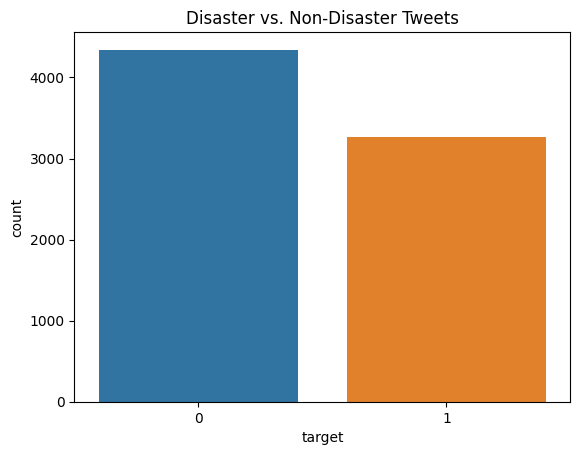

In [5]:
# Checking for null values and basic statistics
df.info()

# Visualizing the distribution of the target
sns.countplot(data=df, x='target')
plt.title('Disaster vs. Non-Disaster Tweets')
plt.show()

## 2. Data Preprocessing

We will clean and preprocess the text data by removing stopwords, tokenizing, and lemmatizing.

In [6]:
# Preprocessing functions
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = re.sub(r'http\S+', '', text.lower())  # Remove URLs
    text = re.sub(r'[^a-z\s]', '', text)  # Remove non-alphabetic characters
    tokens = word_tokenize(text) # Tokenize text
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word.isalpha() and word not in stop_words]
    return ' '.join(tokens)

# Apply preprocessing
df['text_cleaned'] = df['text'].apply(preprocess_text)
df[['text', 'text_cleaned']].head()

,text,text_cleaned
0,Our Deeds are the Reason of this #earthquake M...,deed reason earthquake may allah forgive u
1,Forest fire near La Ronge Sask. Canada,forest fire near la ronge sask canada
2,All residents asked to 'shelter in place' are ...,resident asked shelter place notified officer ...
3,"13,000 people receive #wildfires evacuation or...",people receive wildfire evacuation order calif...
4,Just got sent this photo from Ruby #Alaska as ...,got sent photo ruby alaska smoke wildfire pour...


## 3. Naive Bayes Model with TF-IDF

We will vectorize the text data using TF-IDF and train a Naive Bayes model.

In [7]:
# TF-IDF Vectorization
tfidf = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf.fit_transform(df['text_cleaned']).toarray()
y = df['target']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

# Train Naive Bayes model
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

# Evaluate
y_pred_nb = nb_model.predict(X_test)
print("Naive Bayes Accuracy:", accuracy_score(y_test, y_pred_nb))
print(classification_report(y_test, y_pred_nb))

Naive Bayes Accuracy: 0.8010505581089954
              precision    recall  f1-score   support

           0       0.79      0.88      0.84       874
           1       0.81      0.69      0.75       649

    accuracy                           0.80      1523
   macro avg       0.80      0.79      0.79      1523
weighted avg       0.80      0.80      0.80      1523



## 4. LSTM Model

Next, we will use an LSTM model with embedding and padding for sequence processing.

In [8]:
# Tokenization and Padding
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(df['text_cleaned'])
X_seq = tokenizer.texts_to_sequences(df['text_cleaned'])
X_seq_padded = pad_sequences(X_seq, maxlen=50)

# Train-test split
X_train_seq, X_test_seq, y_train_seq, y_test_seq = train_test_split(X_seq_padded, y, test_size=0.2, random_state=42)

# Build LSTM model
lstm_model = Sequential([
    Embedding(5000, 128, input_length=50),
    SpatialDropout1D(0.2),
    LSTM(100, dropout=0.2, recurrent_dropout=0.2),
    Dense(1, activation='sigmoid')
])

# Compile the model
lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
lstm_model.summary()

# Train the model
lstm_model.fit(X_train_seq, y_train_seq, epochs=5, batch_size=32, validation_split=0.1, verbose=2)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ ?                      │   0 (unbuilt) │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
172/172 - 16s - 95ms/step - accuracy: 0.7095 - loss: 0.5535 - val_accuracy: 0.8144 - val_loss: 0.4361
Epoch 2/5
172/172 - 11s - 62ms/step - accuracy: 0.8462 - loss: 0.3559 - val_accuracy: 0.7931 - val_loss: 0.4391
Epoch 3/5
172/172 - 11s - 64ms/step - accuracy: 0.8871 - loss: 0.2760 - val_accuracy: 0.7898 - val_loss: 0.4876
Epoch 4/5
172/172 - 11s - 62ms/step - accuracy: 0.9128 - loss: 0.2233 - val_accuracy: 0.7767 - val_loss: 0.5767
Epoch 5/5
172/172 - 11s - 62ms/step - accuracy: 0.9332 - loss: 0.1801 - val_accuracy: 0.7750 - val_loss: 0.6536


In [9]:
# Evaluate LSTM model
y_pred_lstm = (lstm_model.predict(X_test_seq) > 0.5).astype('int32')
print("LSTM Accuracy:", accuracy_score(y_test_seq, y_pred_lstm))
print(classification_report(y_test_seq, y_pred_lstm))

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
LSTM Accuracy: 0.7649376231122784
              precision    recall  f1-score   support

           0       0.79      0.80      0.80       874
           1       0.73      0.71      0.72       649

    accuracy                           0.76      1523
   macro avg       0.76      0.76      0.76      1523
weighted avg       0.76      0.76      0.76      1523



## 5. CatBoost with Text Features

CatBoost can handle text data directly. Here, we will use CatBoost to classify disaster tweets based on raw text features.

In [10]:
# Prepare data for CatBoost
X_train_cat, X_test_cat, y_train_cat, y_test_cat = train_test_split(df['text'], df['target'], test_size=0.2, random_state=42)

# Convert Series to DataFrame
X_train_cat = X_train_cat.to_frame()
X_test_cat = X_test_cat.to_frame()

# Create Pool for CatBoost
train_pool = Pool(data=X_train_cat, label=y_train_cat, text_features=[0])
test_pool = Pool(data=X_test_cat, label=y_test_cat, text_features=[0])

# Initialize and train CatBoost model
catboost_model = CatBoostClassifier(iterations=2000, learning_rate=0.1, depth=6, loss_function='Logloss', verbose=100)
catboost_model.fit(train_pool, eval_set=test_pool, use_best_model=True)

0:	learn: 0.6624518	test: 0.6583858	best: 0.6583858 (0)	total: 166ms	remaining: 5m 31s
100:	learn: 0.4568896	test: 0.4579677	best: 0.4578925 (98)	total: 12s	remaining: 3m 45s
200:	learn: 0.4132191	test: 0.4535005	best: 0.4529887 (170)	total: 23.6s	remaining: 3m 31s
300:	learn: 0.3782115	test: 0.4539809	best: 0.4529062 (254)	total: 35.3s	remaining: 3m 19s
400:	learn: 0.3506587	test: 0.4569931	best: 0.4529062 (254)	total: 47.4s	remaining: 3m 8s
500:	learn: 0.3262919	test: 0.4593284	best: 0.4529062 (254)	total: 59.1s	remaining: 2m 56s
600:	learn: 0.3042914	test: 0.4613751	best: 0.4529062 (254)	total: 1m 10s	remaining: 2m 45s
700:	learn: 0.2834957	test: 0.4641118	best: 0.4529062 (254)	total: 1m 22s	remaining: 2m 32s
800:	learn: 0.2667552	test: 0.4677696	best: 0.4529062 (254)	total: 1m 34s	remaining: 2m 20s
900:	learn: 0.2516866	test: 0.4726409	best: 0.4529062 (254)	total: 1m 45s	remaining: 2m 9s
1000:	learn: 0.2380751	test: 0.4753917	best: 0.4529062 (254)	total: 1m 57s	remaining: 1m 57s
11

In [11]:
# Evaluate CatBoost model
y_pred_catboost = catboost_model.predict(test_pool)
print("CatBoost Accuracy:", accuracy_score(y_test_cat, y_pred_catboost))
print(classification_report(y_test_cat, y_pred_catboost))

CatBoost Accuracy: 0.7944845699277742
              precision    recall  f1-score   support

           0       0.78      0.89      0.83       874
           1       0.82      0.66      0.73       649

    accuracy                           0.79      1523
   macro avg       0.80      0.78      0.78      1523
weighted avg       0.80      0.79      0.79      1523



## 🎓 Conclusion

In this notebook, we explored three models:
- **Naive Bayes** with TF-IDF features
- **LSTM** for sequence classification
- **CatBoost** with native text handling capabilities

Each approach has its strengths. **Naive Bayes** is fast and performs well with TF-IDF vectors, **LSTM** captures sequential patterns in text data, and **CatBoost** provides a straightforward approach by directly using raw text data.